In [ ]:
# https://learnopencv.com/face-swap-using-opencv-c-python/#download

# just experiments

In [ ]:
!git clone https://github.com/FacePerceiver/facer.git
!git clone https://github.com/willyfh/farl-face-segmentation.git

!pip install -q validators
!pip install -q timm

fatal: destination path 'facer' already exists and is not an empty directory.


In [ ]:
import facer.facer as ff
import os
import asyncio
import numpy as np
import cv2

import torch
import functools
from facer.facer.transform import (get_face_align_matrix, make_inverted_tanh_warp_grid,
                                                make_tanh_warp_grid)

import matplotlib.pyplot as plt
from PIL import Image
from typing import Dict, List


face_label_mapping = {
    'background': 0,
    'neck': 0,
    'face': 1,
    'cloth': 0,
    'rr': 0,
    'lr': 0,
    'rb': 1,
    'lb': 1,
    're': 1,
    'le': 1,
    'nose': 1,
    'imouth': 1,
    'llip': 1,
    'ulip': 1,
    'hair': 0,
    'eyeg': 1,
    'hat': 0,
    'earr': 0,
    'neckl': 0
}

def crop_face(input_image: np.array, mask_image: np.array) -> np.array:
    cropped_image = cv2.multiply(np.array(input_image), (mask_image / 255).astype(np.uint8))
    return cropped_image


def map_face_label(seg_labels: torch.Tensor, data: Dict[str, torch.Tensor]):
    """
    Map the face parsing label to face segmentation label (0: background, 1: face)
    """
    for i in range(len(seg_labels)):
        for j in range(len(seg_labels[i])):
            seg_labels[i][j] = face_label_mapping[data['seg']['label_names'][seg_labels[i][j]]]


def extract_face_mask(data: Dict[str, torch.Tensor]) -> np.array:
    seg_logits = data['seg']['logits']
    seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w

    predicted_labels = seg_probs.argmax(dim=1).int()

    map_face_label(predicted_labels[0], data)

    mask_image = (predicted_labels * 255)
    mask_image = mask_image.permute(1, 2, 0)  # c x h x w -> h x w x c
    mask_image = mask_image.repeat(1, 1, 3).permute(2, 0, 1)  # h x w x c -> c x h x w
    mask_image = mask_image.to(torch.uint8).cpu().numpy()
    return mask_image


def segment_input_image(input_image: np.array, mask_image: np.array, face_color: List[int]) -> (np.array, np.array):
    non_face_image = cv2.multiply(np.array(input_image), (1 - (mask_image / 255)).astype(np.uint8))
    cropped_face_image = crop_face(input_image, mask_image)
    return cropped_face_image


def mask_extractor(image: torch.Tensor) -> tuple[torch.Tensor]:
    device = "cpu"

    # convert the image
    image = image.unsqueeze(0)

    # load the pretrained models
    face_detector = ff.face_detector("retinaface/resnet50", device=device)
    face_parser = ff.face_parser("farl/celebm/448", device=device)
    face_aligner = ff.face_aligner('farl/ibug300w/448', device=device)  # optional: "farl/wflw/448", "farl/aflw19/448"

    # detect the face
    with torch.inference_mode():

        det_faces = face_detector(image)

    # predict the segmentation
    with torch.inference_mode():
        faces = face_parser(image, det_faces)

    with torch.inference_mode():
        faces_landmarks = face_aligner(image, det_faces)

    facial_keypoints = faces_landmarks['alignment']

    mask_image = extract_face_mask(faces)
    cropped_face_image = segment_input_image(np.array(image[0]), mask_image, [255, 129, 54])
    return mask_image, cropped_face_image, facial_keypoints

In [ ]:
import facer.facer as ff

img_file_tgt = '/content/face3.jpg'
img_file_src = '/content/sui.jpg'
# image: 1 x 3 x h x w

image_tgt = ff.hwc2bchw(ff.read_hwc(img_file_tgt)).to('cpu') [0, ...]
image_src = ff.hwc2bchw(ff.read_hwc(img_file_src)).to('cpu') [0, ...]

mask_image_tgt, cropped_face_image_tgt, facial_keypoints_tgt = mask_extractor(image_tgt)
mask_image_src, cropped_face_image_src, facial_keypoints_src = mask_extractor(image_src)

1 image.shape=torch.Size([3, 927, 760])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


2 image.shape=torch.Size([1, 3, 927, 760])
1 image.shape=torch.Size([3, 1125, 988])
2 image.shape=torch.Size([1, 3, 1125, 988])


In [ ]:
cv2.imread(img_file_tgt).shape, image_tgt.shape

((927, 760, 3), torch.Size([3, 927, 760]))

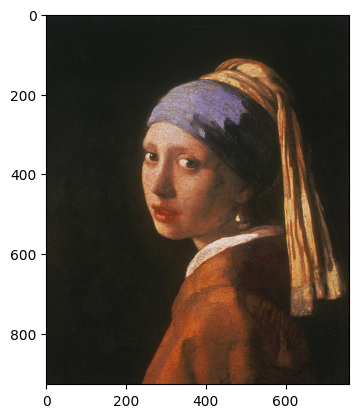

In [ ]:
plt.imshow(image_tgt.numpy().transpose(1, 2, 0))

In [ ]:
import gc
gc.collect()

7799

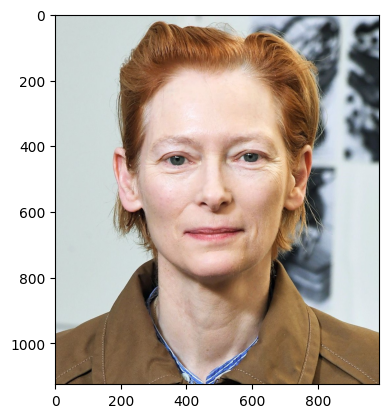

In [ ]:
plt.imshow(image_src.numpy().transpose(1, 2, 0))

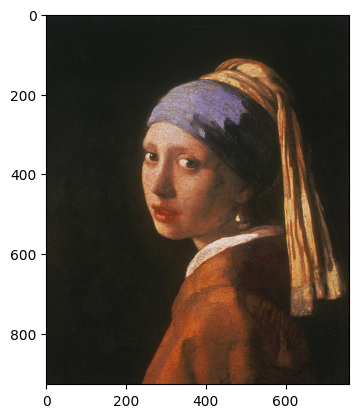

In [ ]:
plt.imshow(image_tgt.numpy().transpose(1, 2, 0))

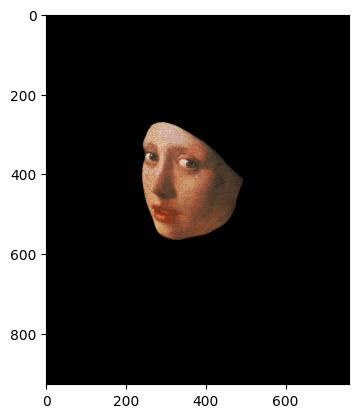

In [ ]:
plt.imshow(cropped_face_image_tgt.transpose(1, 2, 0))

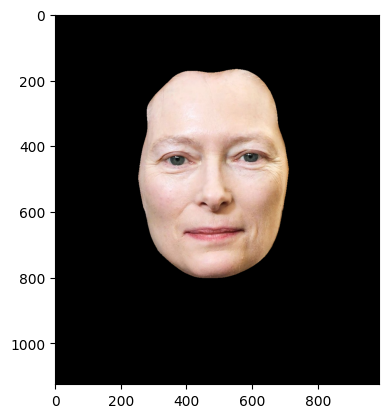

In [ ]:
plt.imshow(cropped_face_image_src.transpose(1, 2, 0))


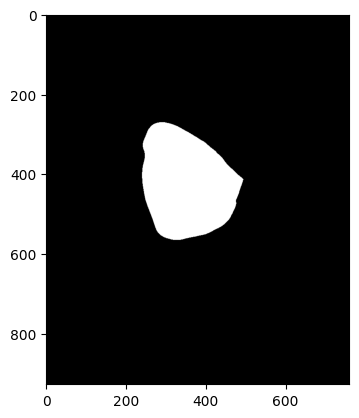

In [ ]:
plt.imshow(mask_image_tgt.transpose(1, 2, 0))

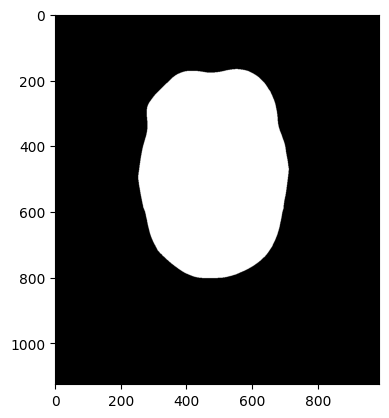

In [ ]:
plt.imshow(mask_image_src.transpose(1, 2, 0))

In [ ]:
# https://github.com/spmallick/learnopencv/tree/master/FaceSwap
# https://github.com/spmallick/learnopencv/tree/master/FaceMorph

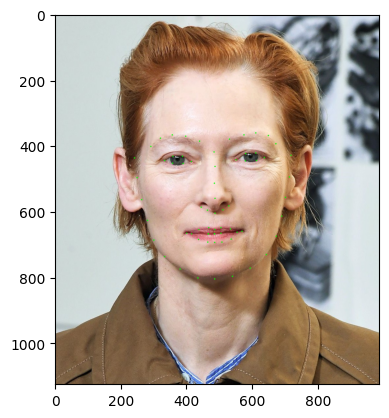

In [ ]:
img = cv2.imread(img_file_src)[..., ::-1]
vis_img = img.copy()
for pts in facial_keypoints_src:
    vis_img = ff.draw_landmarks(vis_img, None, pts.cpu().numpy())
plt.imshow(vis_img)

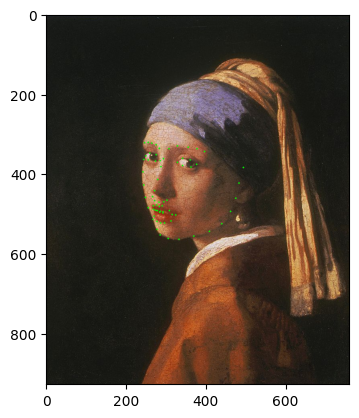

In [ ]:
img = cv2.imread(img_file_tgt)[..., ::-1]
vis_img = img.copy()
for pts in facial_keypoints_tgt:
    vis_img = ff.draw_landmarks(vis_img, None, pts.cpu().numpy())
plt.imshow(vis_img)

In [ ]:
# https://learnopencv.com/face-swap-using-opencv-c-python/#download
import cv2
import numpy as np

points_tgt = np.array(facial_keypoints_tgt)[0, :, :]
points_src = np.array(facial_keypoints_src)[0, :, :]

hullIndex_tgt = cv2.convexHull(points_tgt, returnPoints = False)

In [ ]:
hullIndex_tgt

array([[16],
       [14],
       [13],
       [12],
       [11],
       [10],
       [ 9],
       [ 8],
       [ 7],
       [ 6],
       [ 5],
       [ 4],
       [ 3],
       [ 2],
       [ 1],
       [17],
       [18],
       [24],
       [25],
       [26]], dtype=int32)

In [ ]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html

from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
# rng = np.random.default_rng()
# points = rng.random((30, 2))   # 30 random points in 2-D
hull = ConvexHull(points_tgt)

In [ ]:
hull.vertices

array([ 1, 17, 18, 24, 25, 26, 16, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,
        4,  3,  2], dtype=int32)

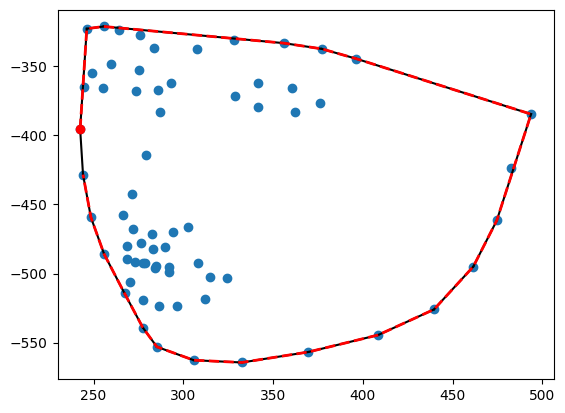

In [ ]:
import matplotlib.pyplot as plt
plt.plot(points_tgt[:,0], -points_tgt[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points_tgt[simplex, 0], -points_tgt[simplex, 1], 'k-')
# We could also have directly used the vertices of the hull, which for 2-D are guaranteed to be in counterclockwise order:

plt.plot(points_tgt[hull.vertices,0], -points_tgt[hull.vertices,1], 'r--', lw=2)
plt.plot(points_tgt[hull.vertices[0],0], -points_tgt[hull.vertices[0],1], 'ro')
plt.show()

In [ ]:
def rectContains(rect, point) :
    """
    Check if a point is inside a rectangle
    """

    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True

In [ ]:
def calculateDelaunayTriangles(rect, points):
    """
    Calculate the Delaunay triangles
    """
    #create subdiv
    subdiv = cv2.Subdiv2D(rect);

    # Insert points into subdiv
    for p in points:
        subdiv.insert(tuple(p))

    triangleList = subdiv.getTriangleList();

    delaunayTri = []

    pt = []

    for t in triangleList:
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))

        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])

        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            #Get face-points (from 68 face detector) by coordinates
            for j in range(0, 3):
                for k in range(0, len(points)):
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)
            # Three points form a triangle. Triangle array corresponds to the file tri.txt in FaceMorph
            if len(ind) == 3:
                delaunayTri.append((ind[0], ind[1], ind[2]))

        pt = []


    return delaunayTri

In [ ]:
def applyAffineTransform(src, srcTri, dstTri, size) :
    """
    Apply affine transform calculated using srcTri and dstTri to src and
    output an image of size.
    """

    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri))

    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine(src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst

In [ ]:
def warpTriangle(img1, img2, t1, t2, mask) :
    """
    Warps and alpha blends triangular regions from img1 and img2 to img
    """

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = []
    t2Rect = []
    t2RectInt = []

    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2Rect = np.zeros((r2[3], r2[2]), dtype = img1Rect.dtype)

    size = (r2[2], r2[3])

    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)

    img2Rect = img2Rect * mask

    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )

    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect


In [ ]:
points_src = points_src.tolist()
points_tgt = points_tgt.tolist()

In [ ]:
hull_src, hull_tgt = [], []
img1Warped = np.copy(image_tgt.numpy().transpose(1, 2, 0))

for i in range(0, len(hullIndex_tgt)):
    hull_src.append(tuple(points_src[int(hullIndex_tgt[i])]))
    hull_tgt.append(tuple(points_tgt[int(hullIndex_tgt[i])]))


# Find delanauy traingulation for convex hull points
sizeImg_tgt = image_tgt.shape
rect = (0, 0, sizeImg_tgt[-1], sizeImg_tgt[1])

dt = calculateDelaunayTriangles(rect, hull_tgt)

if len(dt) == 0:
    quit()

# Apply affine transformation to Delaunay triangles
for i in range(0, len(dt)):
    t1 = []
    t2 = []

    #get points for image_src, image_tgt corresponding to the triangles
    for j in range(0, 3):
        t1.append(hull_src[dt[i][j]])
        t2.append(hull_tgt[dt[i][j]])

    warpTriangle(image_src.numpy().transpose(1, 2, 0), img1Warped, t1, t2)


r = cv2.boundingRect(np.float32([hull_tgt]))

center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))

In [ ]:
# https://learnopencv.com/face-morph-using-opencv-cpp-python/
# https://learnopencv.com/seamless-cloning-using-opencv-python-cpp/
# https://www.cs.jhu.edu/~misha/Fall07/Papers/Perez03.pdf

# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(img1Warped), image_tgt.numpy().transpose(1, 2, 0), mask_image_tgt.transpose(1, 2, 0), center, cv2.NORMAL_CLONE)


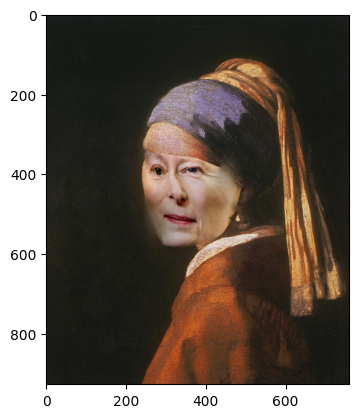

In [ ]:
plt.imshow(output)

# in functions

In [ ]:
!git clone https://github.com/FacePerceiver/facer.git
!git clone https://github.com/willyfh/farl-face-segmentation.git

!pip install -q validators
!pip install -q timm

fatal: destination path 'facer' already exists and is not an empty directory.
fatal: destination path 'farl-face-segmentation' already exists and is not an empty directory.


In [ ]:
import facer.facer as ff
import os
import asyncio
import numpy as np
import cv2

import torch
import functools
from facer.facer.transform import (get_face_align_matrix, make_inverted_tanh_warp_grid,
                                                make_tanh_warp_grid)

import matplotlib.pyplot as plt
from PIL import Image
from typing import Dict, List


face_label_mapping = {
    'background': 0,
    'neck': 0,
    'face': 1,
    'cloth': 0,
    'rr': 0,
    'lr': 0,
    'rb': 1,
    'lb': 1,
    're': 1,
    'le': 1,
    'nose': 1,
    'imouth': 1,
    'llip': 1,
    'ulip': 1,
    'hair': 0,
    'eyeg': 1,
    'hat': 0,
    'earr': 0,
    'neckl': 0
}

def crop_face(input_image: np.array, mask_image: np.array) -> np.array:
    cropped_image = cv2.multiply(np.array(input_image), (mask_image / 255).astype(np.uint8))
    return cropped_image


def map_face_label(seg_labels: torch.Tensor, data: Dict[str, torch.Tensor]):
    """
    Map the face parsing label to face segmentation label (0: background, 1: face)
    """
    for i in range(len(seg_labels)):
        for j in range(len(seg_labels[i])):
            seg_labels[i][j] = face_label_mapping[data['seg']['label_names'][seg_labels[i][j]]]


def extract_face_mask(data: Dict[str, torch.Tensor]) -> np.array:
    seg_logits = data['seg']['logits']
    seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w

    predicted_labels = seg_probs.argmax(dim=1).int()

    map_face_label(predicted_labels[0], data)

    mask_image = (predicted_labels * 255)
    mask_image = mask_image.permute(1, 2, 0)  # c x h x w -> h x w x c
    mask_image = mask_image.repeat(1, 1, 3).permute(2, 0, 1)  # h x w x c -> c x h x w
    mask_image = mask_image.to(torch.uint8).cpu().numpy()
    return mask_image


def segment_input_image(input_image: np.array, mask_image: np.array, face_color: List[int]) -> (np.array, np.array):
    non_face_image = cv2.multiply(np.array(input_image), (1 - (mask_image / 255)).astype(np.uint8))
    cropped_face_image = crop_face(input_image, mask_image)
    return cropped_face_image


def mask_extractor(image: torch.Tensor) -> tuple[torch.Tensor]:
    device = "cpu"

    # convert the image
    image = image.unsqueeze(0)

    # load the pretrained models
    face_detector = ff.face_detector("retinaface/resnet50", device=device)
    face_parser = ff.face_parser("farl/celebm/448", device=device)
    face_aligner = ff.face_aligner('farl/ibug300w/448', device=device)  # optional: "farl/wflw/448", "farl/aflw19/448"

    with torch.inference_mode():
        det_faces = face_detector(image)  # detect the face
        # return det_faces
        best_id = torch.argmax(det_faces['scores']).item()
        det_faces = {key: value[best_id].unsqueeze(0) for key, value in det_faces.items()}

        faces = face_parser(image, det_faces)  # predict the segmentation
        faces_landmarks = face_aligner(image, det_faces)  # align the face

    facial_keypoints = faces_landmarks['alignment']

    # return det_faces
    mask_image = extract_face_mask(faces)
    cropped_face_image = segment_input_image(np.array(image[0]), mask_image, [255, 129, 54])

    return mask_image, cropped_face_image, facial_keypoints, det_faces

In [ ]:
def rectContains(rect, point) :
    """
    Check if a point is inside a rectangle
    """

    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True

In [ ]:
def calculateDelaunayTriangles(rect, points):
    """
    Calculate the Delaunay triangles
    """
    #create subdiv
    subdiv = cv2.Subdiv2D(rect);

    # Insert points into subdiv
    for p in points:
        subdiv.insert(tuple(p))

    triangleList = subdiv.getTriangleList();

    delaunayTri = []

    pt = []

    for t in triangleList:
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))

        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])

        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            #Get face-points (from 68 face detector) by coordinates
            for j in range(0, 3):
                for k in range(0, len(points)):
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)
            # Three points form a triangle. Triangle array corresponds to the file tri.txt in FaceMorph
            if len(ind) == 3:
                delaunayTri.append((ind[0], ind[1], ind[2]))

        pt = []


    return delaunayTri

In [ ]:
def applyAffineTransform(src, srcTri, dstTri, size) :
    """
    Apply affine transform calculated using srcTri and dstTri to src and
    output an image of size.
    """

    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri))

    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine(src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    return dst

In [ ]:
def warpTriangle(img1, img2, t1, t2) :
    """
    Warps and alpha blends triangular regions from img1 and img2 to img
    """

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = []
    t2Rect = []
    t2RectInt = []

    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2Rect = np.zeros((r2[3], r2[2]), dtype = img1Rect.dtype)

    size = (r2[2], r2[3])

    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)

    img2Rect = img2Rect * mask

    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ((1.0, 1.0, 1.0) - mask)

    img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect


In [ ]:
import facer.facer as ff
import cv2
import numpy as np


def main(img_file_tgt, img_file_src):
    image_tgt = ff.hwc2bchw(ff.read_hwc(img_file_tgt)).to('cpu') [0, ...]
    image_src = ff.hwc2bchw(ff.read_hwc(img_file_src)).to('cpu') [0, ...]

    mask_image_tgt, cropped_face_image_tgt, facial_keypoints_tgt, det_faces_tgt = mask_extractor(image_tgt)
    mask_image_src, cropped_face_image_src, facial_keypoints_src, det_faces_src = mask_extractor(image_src)

    # https://learnopencv.com/face-swap-using-opencv-c-python/#download

    points_tgt = np.array(facial_keypoints_tgt)[0, :, :]
    points_src = np.array(facial_keypoints_src)[0, :, :]

    hullIndex_tgt = cv2.convexHull(points_tgt, returnPoints = False)

    points_src = points_src.tolist()
    points_tgt = points_tgt.tolist()

    hull_src, hull_tgt = [], []
    img1Warped = np.copy(image_tgt.numpy().transpose(1, 2, 0))

    for i in range(0, len(hullIndex_tgt)):
        hull_src.append(tuple(points_src[int(hullIndex_tgt[i])]))
        hull_tgt.append(tuple(points_tgt[int(hullIndex_tgt[i])]))


    # Find delanauy traingulation for convex hull points
    sizeImg_tgt = image_tgt.shape
    rect = (0, 0, sizeImg_tgt[-1], sizeImg_tgt[1])

    dt = calculateDelaunayTriangles(rect, hull_tgt)

    if len(dt) == 0:
        quit()

    # Apply affine transformation to Delaunay triangles
    for i in range(0, len(dt)):
        t1 = []
        t2 = []

        #get points for image_src, image_tgt corresponding to the triangles
        for j in range(0, 3):
            t1.append(hull_src[dt[i][j]])
            t2.append(hull_tgt[dt[i][j]])

        warpTriangle(image_src.numpy().transpose(1, 2, 0), img1Warped, t1, t2)


    r = cv2.boundingRect(np.float32([hull_tgt]))
    center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))

    # https://learnopencv.com/face-morph-using-opencv-cpp-python/
    # https://learnopencv.com/seamless-cloning-using-opencv-python-cpp/
    # https://www.cs.jhu.edu/~misha/Fall07/Papers/Perez03.pdf

    # Clone seamlessly.
    output = cv2.seamlessClone(np.uint8(img1Warped), image_tgt.numpy().transpose(1, 2, 0), mask_image_tgt.transpose(1, 2, 0), center, cv2.NORMAL_CLONE)

    return output


In [ ]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [ ]:
selfie = 'sui.jpg'
paint = 'photo_1.jpg'
dir_name = '/content/'

path_selfie_name = os.path.join(dir_name, selfie)
path_painting_name = os.path.join(dir_name, paint)
out_name = 'results/' + paint.split('.')[0] + '__' + selfie
# print(out_name)

output = main(path_painting_name, path_selfie_name)
# print(os.path.join(dir_name, out_name))
cv2.imwrite(os.path.join(dir_name, out_name), output)

In [ ]:
import os
from tqdm import tqdm
import gc

paintings = ['photo_1.jpg', 'photo_2.jpg', 'photo_3.jpg', 'photo_4.jpg', 'photo_5.jpg']
selfies = ['ein.jpg', 'jim.jpg', 'oliv.jpg', 'tom.png', 'will.jpg', 'sui.jpg']

dir_name = '/content/'
for paint in tqdm(paintings, desc='Paintings'):
    for selfie in tqdm(selfies, desc='Selfies'):

        gc.collect()
        print()
        print(paint, selfie)
        path_selfie_name = os.path.join(dir_name, selfie)
        path_painting_name = os.path.join(dir_name, paint)
        out_name = 'results/' + paint.split('.')[0] + '__' + selfie
        # print(out_name)

        output = main(path_painting_name, path_selfie_name)
        # print(os.path.join(dir_name, out_name))
        cv2.imwrite(os.path.join(dir_name, out_name), cv2.cvtColor(output, cv2.COLOR_RGB2BGR))



Selfies:   0%|          | 0/6 [00:00<?, ?it/s]


photo_1.jpg ein.jpg


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)

Selfies:  17%|█▋        | 1/6 [01:15<06:19, 75.88s/it]


photo_1.jpg jim.jpg



Selfies:  33%|███▎      | 2/6 [02:49<05:44, 86.03s/it]


photo_1.jpg oliv.jpg



Selfies:  50%|█████     | 3/6 [04:14<04:16, 85.56s/it]


photo_1.jpg tom.png



Selfies:  67%|██████▋   | 4/6 [05:55<03:03, 91.72s/it]


photo_1.jpg will.jpg



Selfies:  83%|████████▎ | 5/6 [07:07<01:24, 84.63s/it]


photo_1.jpg sui.jpg



Selfies:   0%|          | 0/6 [00:00<?, ?it/s]


photo_2.jpg ein.jpg



Selfies:  17%|█▋        | 1/6 [03:40<18:22, 220.59s/it]


photo_2.jpg jim.jpg



Selfies:  33%|███▎      | 2/6 [07:41<15:29, 232.45s/it]


photo_2.jpg oliv.jpg



Selfies:  50%|█████     | 3/6 [11:41<11:47, 235.88s/it]


photo_2.jpg tom.png



Selfies:  67%|██████▋   | 4/6 [15:54<08:05, 242.52s/it]


photo_2.jpg will.jpg



Selfies:  83%|████████▎ | 5/6 [19:35<03:54, 234.93s/it]


photo_2.jpg sui.jpg



Selfies:   0%|          | 0/6 [00:00<?, ?it/s]


photo_3.jpg ein.jpg



Selfies:  17%|█▋        | 1/6 [01:12<06:00, 72.03s/it]


photo_3.jpg jim.jpg



Selfies:  33%|███▎      | 2/6 [02:45<05:38, 84.53s/it]


photo_3.jpg oliv.jpg



Selfies:  50%|█████     | 3/6 [04:11<04:16, 85.43s/it]


photo_3.jpg tom.png



Selfies:  67%|██████▋   | 4/6 [05:54<03:04, 92.14s/it]


photo_3.jpg will.jpg



Selfies:  83%|████████▎ | 5/6 [07:09<01:26, 86.09s/it]


photo_3.jpg sui.jpg



Selfies:   0%|          | 0/6 [00:00<?, ?it/s]


photo_4.jpg ein.jpg



Selfies:  17%|█▋        | 1/6 [01:53<09:28, 113.61s/it]


photo_4.jpg jim.jpg



Selfies:  33%|███▎      | 2/6 [04:08<08:25, 126.31s/it]


photo_4.jpg oliv.jpg



Selfies:  50%|█████     | 3/6 [06:17<06:21, 127.19s/it]


photo_4.jpg tom.png



Selfies:  67%|██████▋   | 4/6 [08:42<04:28, 134.40s/it]


photo_4.jpg will.jpg



Selfies:  83%|████████▎ | 5/6 [10:42<02:09, 129.37s/it]


photo_4.jpg sui.jpg



Selfies:   0%|          | 0/6 [00:00<?, ?it/s]


photo_5.jpg ein.jpg



Selfies:  17%|█▋        | 1/6 [01:13<06:09, 73.95s/it]


photo_5.jpg jim.jpg



Selfies:  33%|███▎      | 2/6 [02:49<05:47, 86.81s/it]


photo_5.jpg oliv.jpg



Selfies:  50%|█████     | 3/6 [04:22<04:27, 89.29s/it]


photo_5.jpg tom.png



Selfies:  67%|██████▋   | 4/6 [06:07<03:11, 95.52s/it]


photo_5.jpg will.jpg



Selfies:  83%|████████▎ | 5/6 [07:27<01:30, 90.03s/it]


photo_5.jpg sui.jpg



Paintings: 100%|██████████| 5/5 [1:01:33<00:00, 738.63s/it]


In [ ]:
import gc

gc.collect()

24584

In [ ]:
img_file_tgt = '/content/photo_1.jpg'
img_file_src = '/content/jim.jpg'

image_tgt = ff.hwc2bchw(ff.read_hwc(img_file_tgt)).to('cpu') [0, ...]
image_src = ff.hwc2bchw(ff.read_hwc(img_file_src)).to('cpu') [0, ...]

In [ ]:
image_tgt.shape

torch.Size([3, 927, 760])

In [ ]:
import facer.facer as ff
import cv2
import numpy as np

img_file_tgt = '/content/photo_1.jpg'
img_file_src = '/content/jim.jpg'

image_tgt = ff.hwc2bchw(ff.read_hwc(img_file_tgt)).to('cpu') [0, ...]
image_src = ff.hwc2bchw(ff.read_hwc(img_file_src)).to('cpu') [0, ...]

mask_image_tgt, cropped_face_image_tgt, facial_keypoints_tgt, det_faces_tgt = mask_extractor(image_tgt)
mask_image_src, cropped_face_image_src, facial_keypoints_src, det_faces_src = mask_extractor(image_src)


# https://learnopencv.com/face-swap-using-opencv-c-python/#download

points_tgt = np.array(facial_keypoints_tgt)[0, :, :]
points_src = np.array(facial_keypoints_src)[0, :, :]

hullIndex_tgt = cv2.convexHull(points_tgt, returnPoints = False)

points_src = points_src.tolist()
points_tgt = points_tgt.tolist()

hull_src, hull_tgt = [], []
img1Warped = np.copy(image_tgt.numpy().transpose(1, 2, 0))

for i in range(0, len(hullIndex_tgt)):
    hull_src.append(tuple(points_src[int(hullIndex_tgt[i])]))
    hull_tgt.append(tuple(points_tgt[int(hullIndex_tgt[i])]))


# Find delanauy traingulation for convex hull points
sizeImg_tgt = image_tgt.shape
rect = (0, 0, sizeImg_tgt[-1], sizeImg_tgt[1])

dt = calculateDelaunayTriangles(rect, hull_tgt)

if len(dt) == 0:
    quit()

# Apply affine transformation to Delaunay triangles
for i in range(0, len(dt)):
    t1 = []
    t2 = []

    #get points for image_src, image_tgt corresponding to the triangles
    for j in range(0, 3):
        t1.append(hull_src[dt[i][j]])
        t2.append(hull_tgt[dt[i][j]])

    warpTriangle(image_src.numpy().transpose(1, 2, 0), img1Warped, t1, t2)


r = cv2.boundingRect(np.float32([hull_tgt]))
center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))

print(type(np.uint8(img1Warped)), np.uint8(img1Warped).shape)
print()
print(type(image_tgt.numpy().transpose(1, 2, 0)), image_tgt.numpy().transpose(1, 2, 0).shape)
print()
print(type(mask_image_tgt.transpose(1, 2, 0)), mask_image_tgt.transpose(1, 2, 0).shape)
print()
print(type(center), len(center))

# https://learnopencv.com/face-morph-using-opencv-cpp-python/
# https://learnopencv.com/seamless-cloning-using-opencv-python-cpp/
# https://www.cs.jhu.edu/~misha/Fall07/Papers/Perez03.pdf

# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(img1Warped), image_tgt.numpy().transpose(1, 2, 0), mask_image_tgt.transpose(1, 2, 0), center, cv2.NORMAL_CLONE)


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
output.transpose(2, 0, 1).shape

(3, 927, 760)

In [ ]:
cv2.imwrite('/content/ex.jpg', cv2.cvtColor(output, cv2.COLOR_RGB2BGR))


True

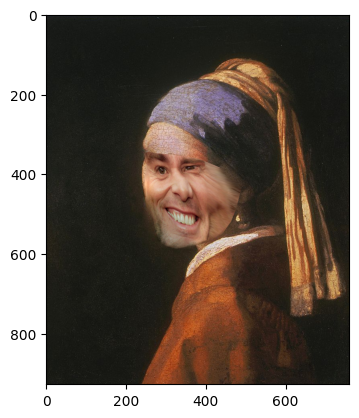

In [ ]:
plt.imshow(output);

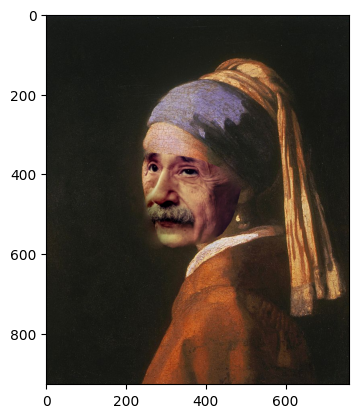

In [ ]:
plt.imshow(output)

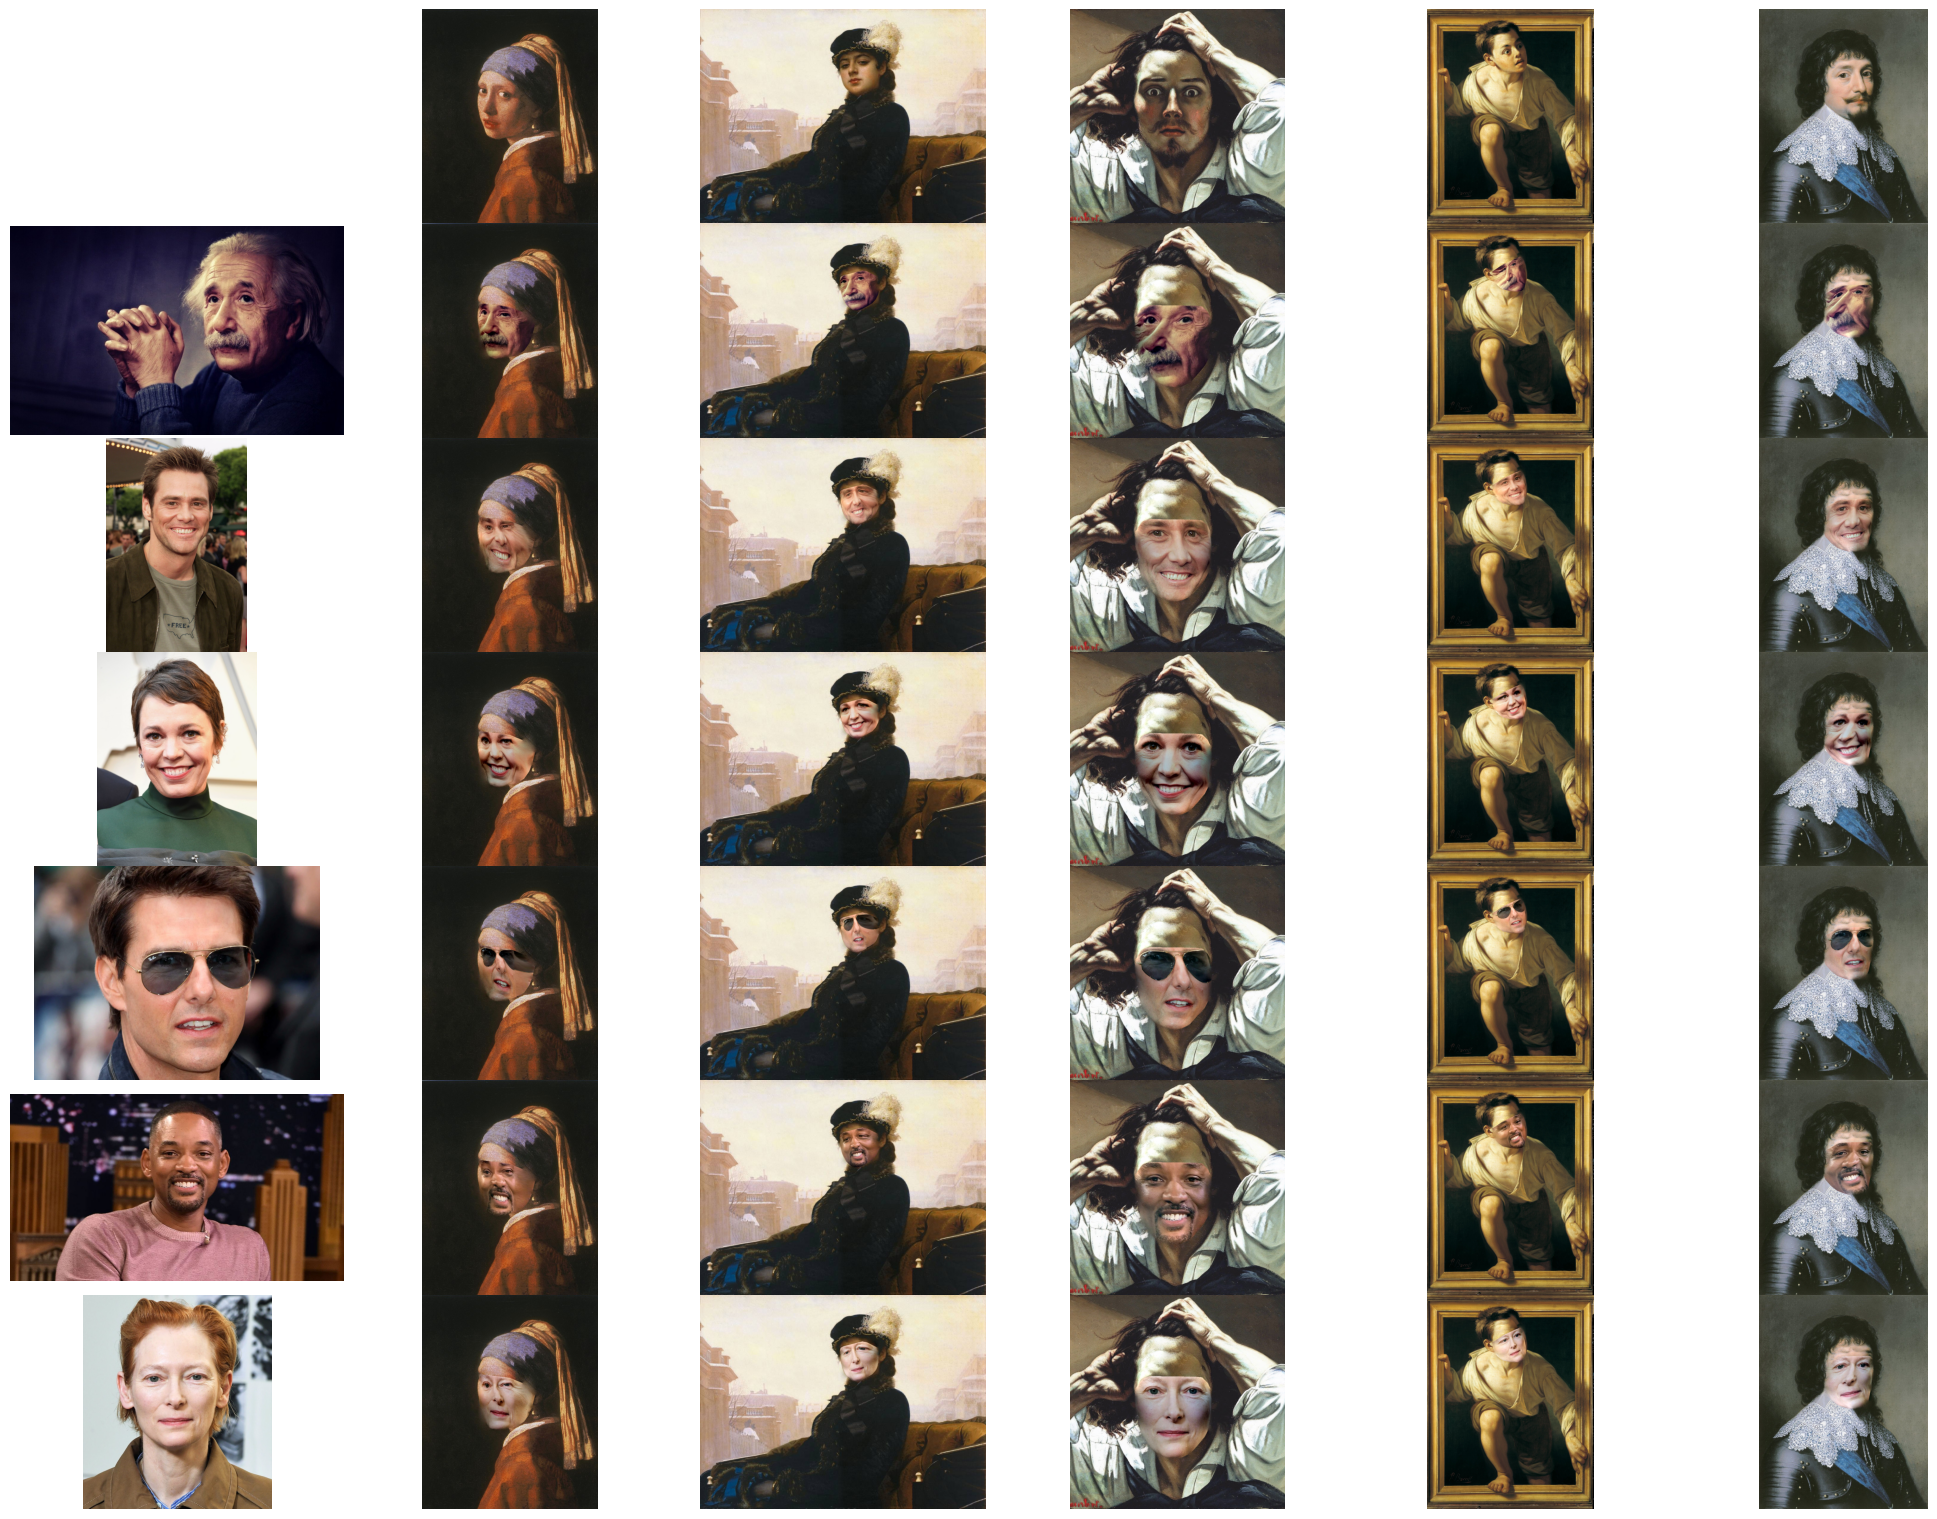

In [ ]:
import matplotlib.pyplot as plt


paintings = ['photo_1.jpg', 'photo_2.jpg', 'photo_3.jpg', 'photo_4.jpg', 'photo_5.jpg']
selfies = ['ein.jpg', 'jim.jpg', 'oliv.jpg', 'tom.jpg', 'will.jpg', 'sui.jpg']

fig, axes = plt.subplots(len(selfies) + 1, len(paintings) + 1, figsize=(20, 15))

name2col = dict(zip(selfies, range(1, len(selfies) + 1)))

for img_name in ([''] + os.listdir('/content/results/')):
    if img_name == '':
        axes[0, 0].axis('off')
        for i, painting in enumerate(paintings):
            axes[0, i + 1].axis('off')
            axes[0, i + 1].set_aspect('equal')
            axes[0, i + 1].imshow(plt.imread(os.path.join('/content/', painting)))

        for i, selfie in enumerate(selfies):
            axes[i + 1, 0].axis('off')
            axes[i + 1, 0].set_aspect('equal')
            axes[i + 1, 0].imshow(plt.imread(os.path.join('/content/', selfie)))

        continue

    elif img_name.endswith(('.jpg', '.png')):

        img_path = os.path.join('/content/results/', img_name)

        col = int(img_name.split('__')[0][-1])
        row = name2col[img_name.split('__')[1]]
        axes[row, col].axis('off')
        axes[row, col].set_aspect('equal')


        axes[row, col].imshow(plt.imread(img_path))

plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
